In [279]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [290]:
def raising_coeff(Fe, Fg, me, mg, Je, Jg):
    I = 1/2 #nuclear spin
    q = me-mg
    cg = CG(Fg, mg, 1, q , Fe, me) #Clebsh-Gordan coeff
    return (float(cg.doit()) 
            * (-1)**(Fg+Je+1+I) 
            * np.sqrt((2*Fg+1)*(2*Je+1)) 
            * float(wigner_6j(Je, Jg, 1, Fg, Fe, I))   
            )

In [291]:
def Rabi(Fg, mFg, Jg, Fe, mFe, Je, intensity, tau, omega):
    
    return (np.sqrt(2*intensity/epsilon0/c)
            *np.sqrt(3*np.pi*epsilon0*hbar*c**3/tau/omega**3)
            *raising_coeff(Fe, Fg, mFe, mFg, Je, Jg)
            /hbar
           )

In [292]:
_lambda = 556e-9
omega_r = 2*np.pi*58e3
m = 171*u
#Delta = 2*np.pi*13e3
omega =  2*np.pi*(4760.247 + 539385645.457)*1e6 #https://journals.aps.org/pra/pdf/10.1103/PhysRevA.100.042505
tau = 866.1e-9

539.3904057039999

In [134]:
#optimal angle
angle_ls = np.linspace(0, np.pi/2, 301)
Rabi_ls = []

for angle in angle_ls:
    E = 1
    Rabi_pi = E*np.cos(angle)*np.sqrt(2/3)
    Rabi_sig = E*np.sin(angle)*np.sqrt(1/3)/2
    Rabi_ls.append(Rabi_sig*Rabi_pi)

angle_opt = angle_ls[int(np.argwhere(Rabi_ls==np.max(Rabi_ls)))]
print('Best angle: %.2f deg' %(angle_opt*180/np.pi))

Best angle: 45.00 deg


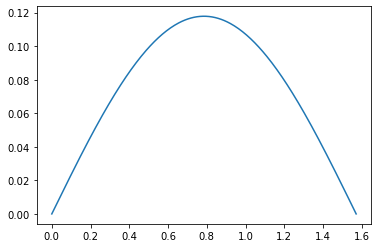

In [135]:
plt.plot(angle_ls, Rabi_ls)

In [136]:
np.argwhere(Rabi_ls==np.max(Rabi_ls))

array([[150]])

0.5000000000000001 0.5
45.00000000000001
0.7500000000000002


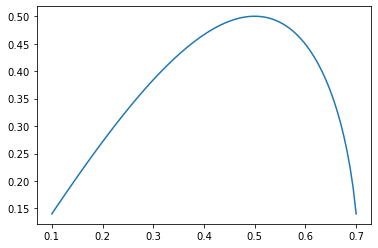

In [137]:
x = np.linspace(0.1,0.7, 100)
y = x*np.sqrt(1-2*x**2)*np.sqrt(2)
plt.plot(x, y)
y0 = np.max(y)
x0 = x[np.argmax(y)]
print(y0,x0)
print(np.arctan(y0/x0)*180/np.pi)
print(x0**2 + 2*y0**2)

In [296]:
w_hor = 3.2e-3 #(400 mm lens)
w_ver = 0.19e-3
Ptot = 0.76*1.5
Ps = Ptot/2/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=75e-6

DeltaR = 2*np.pi*5e9

Omega_p = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Is, tau, omega)

Omega_R = Omega_p*Omega_s/DeltaR

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('Raman Rabi:\n pi ', Omega_R/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_s, tau, omega)

Omega_R_fov = Omega_p_fov*Omega_s_fov/DeltaR

pitime_centre = np.pi/Omega_R

print('Raman Rab at FOV:\n pi ', Omega_R_fov/2/np.pi/1e6, 'MHz')
print('infidelity at FOV:', "{:.2E}".format((np.cos(Omega_R_fov*pitime_centre)*1/2+0.5)))


point = FOV/10*7
Ipoint_p = Ip*np.exp(-2*(point/2)**2/w_hor/w_ver)
Ipoint_s = Is*np.exp(-2*(point/2)**2/w_hor/w_ver)

Omega_p_point = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ipoint_p, tau, omega)
Omega_s_point = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ipoint_s, tau, omega)

Omega_R_point = Omega_p_point*Omega_s_point/DeltaR


pitime_point = np.pi/Omega_R_point

print('infidelity at FOV:', "{:.2E}".format((np.cos(Omega_R_fov*pitime_point)*1/2+0.5)))
print('infidelity at centre:', "{:.2E}".format((np.cos(Omega_R*pitime_point)*1/2+0.5)))





FOV=300e-6
DeltaR = 2*np.pi*10e9

w_hor = 4.5e-3 #(300 mm lens)
w_ver = 0.12e-3
Ptot = 0.72*1.5

ILS = 2*Ptot/np.pi/w_hor/w_ver
Omega_LS = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, ILS, tau, omega)**2 / DeltaR

Ifov_LS = ILS*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Omega_LS_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_LS, tau, omega)**2 /DeltaR

print('LS', Omega_LS/np.pi/1e6, 'MHz')
print('LS fov', Omega_LS_fov/np.pi/1e6, 'MHz')

pitime_centre = np.pi/Omega_LS
print('LS inf %.2E' %(np.cos(Omega_LS_fov*pitime_centre)*1/2+0.5))


point = FOV/10*7
Ipoint_LS = ILS*np.exp(-2*(point/2)**2/w_hor/w_ver)

Omega_LS_point = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ipoint_LS, tau, omega)**2 / DeltaR


pitime_point = np.pi/Omega_LS_point

print('infidelity at FOV:', "{:.2E}".format((np.cos(Omega_LS_fov*pitime_point)*1/2+0.5)))
print('infidelity at centre:', "{:.2E}".format((np.cos(Omega_LS*pitime_point)*1/2+0.5)))




Single Rabi:
 pi  -49.00154125211462 MHz 
 sigma  49.00154125211462 MHz
Raman Rabi:
 pi  -0.48023020901653835 MHz
Raman Rab at FOV:
 pi  -0.47801387949913315 MHz
infidelity at FOV: 5.26E-05
infidelity at FOV: 1.37E-05
infidelity at centre: 1.27E-05
LS 2.0489822251372303 MHz
LS fov 1.8851546519122715 MHz
LS inf 1.57E-02
infidelity at FOV: 4.27E-03
infidelity at centre: 4.28E-03


In [258]:
0.5/.775*100*1e-6

6.451612903225807e-05

In [260]:
a = 5
b = 2
a*b


10

In [261]:
a

5

In [259]:
400/75*0.63

3.36

In [140]:
Omega_LS/1e6

15.198631610980865

In [198]:
0.556e-6/3.14/1.75e-6*6.24

0.6313812556869881

In [248]:
0.556e-6/3.14/0.63e-3*400

0.11242543726620158

In [69]:
0.455e-3*10

0.00455

In [201]:
0.556e-6/3.14/0.4e-3*400

0.17707006369426748

In [76]:
0.4*10

4.0

In [63]:
.3*250/30

2.5

In [21]:
0.45*10

4.5

In [31]:
0.556e-6/3.14/0.63e-3*500

0.14053179658275197

In [64]:
0.556e-6/3.14/0.3e-3*250

0.14755838641188956

In [111]:
np.pi*(0.13e-3)**2/0.556e-6

0.09549085583753146

In [166]:
w_hor = 50e-3
w_ver = 0.1e-3
Ptot = 1
Ps = Ptot*2/4/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=0.30e-3

DeltaR = 2*np.pi*3e9

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

Omega_R = 2*Omega_p*Omega_s/DeltaR

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('Raman Rabi:\n pi ', Omega_R/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Ifov_s, tau, omega)

Omega_R_fov = 2*Omega_p_fov*Omega_s_fov/DeltaR

print('Raman Rab at FOV:\n pi ', Omega_R_fov/2/np.pi/1e6, 'MHz')


pitime_centre = np.pi/Omega_R
print('infidelity at FOV:', "{:.2E}".format(np.cos(Omega_R_fov*pitime_centre)*1/2+0.5))



Single Rabi:
 pi  22.632842426091948 MHz 
 sigma  11.316421213045972 MHz
Raman Rabi:
 pi  0.17074851876143585 MHz
Raman Rab at FOV:
 pi  0.16921867670824225 MHz
infidelity at FOV: 1.98E-04


In [11]:
0.5/236e6

2.1186440677966102e-09

In [12]:
2.11e-9*231e6

0.48741

In [13]:
np.cos(0.4871)

0.8836939615657327

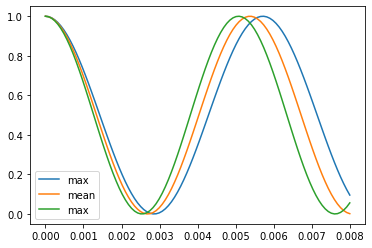

In [22]:
Omega0 = 2*np.pi*(186-11)
Omega1 = 2*np.pi*(186)
Omega2 = 2*np.pi*(186+11)

t = np.linspace(0, 8, 100)*1e-3

plt.plot(t, 0.5*(np.cos(Omega0*t)+1), label='max')
plt.plot(t, 0.5*(np.cos(Omega1*t)+1), label='mean')
plt.plot(t, 0.5*(np.cos(Omega2*t)+1), label='max')
plt.legend()

In [23]:
t1 = np.pi/Omega1

print(0.5*(np.cos(Omega0*t1)+1), 0.5*(np.cos(Omega2*t1)+1))

0.008604974529571041 0.008604974529570986


In [24]:
w_hor = 0.025e-3
w_ver = 0.025e-3
Ptot = 100e-3
Ps = Ptot*2/4/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=0.01e-3

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Ifov_s, tau, omega)

print('Single Rabi:\n pi ', Omega_p_fov/2/np.pi/1e6, 'MHz \n sigma ', Omega_s_fov/2/np.pi/1e6, 'MHz')


pitime_centre = np.pi/Omega_p
print('infidelity at FOV:', "{:.2E}".format(np.cos(Omega_p_fov*pitime_centre)*1/2+0.5))



Single Rabi:
 pi  640.153454280648 MHz 
 sigma  320.07672714032407 MHz
Single Rabi:
 pi  615.0526783097264 MHz 
 sigma  307.5263391548632 MHz
infidelity at FOV: 3.79E-03


In [45]:
w_hor = 1e-3
w_ver = 0.05e-3
Ptot = 1
Ps = Ptot*2/4/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=0.01e-3

DeltaR = 2*np.pi*13e9

Omega_p = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Is, tau, omega)

Omega_R = 2*Omega_p*Omega_s/DeltaR

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('Raman Rabi:\n pi ', Omega_R/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 3/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 3/2, 1/2, 1, Ifov_s, tau, omega)

Omega_R_fov = 2*Omega_p_fov*Omega_s_fov/DeltaR

print('Raman Rab at FOV:\n pi ', Omega_R_fov/2/np.pi/1e6, 'MHz')


pitime_centre = np.pi/Omega_R
print('infidelity at FOV:', "{:.2E}".format(np.cos(Omega_R_fov*pitime_centre)*1/2+0.5))



Single Rabi:
 pi  226.32842426091943 MHz 
 sigma  113.16421213045972 MHz
Raman Rabi:
 pi  3.9403504329562105 MHz
Raman Rab at FOV:
 pi  3.9364120520419106 MHz
infidelity at FOV: 2.46E-06


In [1]:
250/500*75

37.5

In [6]:
0.4*300/40

3.0

In [5]:
0.556/3.14/0.4*300

132.80254777070064

In [122]:
C = 1e-9

In [123]:
R=1/2/np.pi/C/5e6

In [124]:
R

31.830988618379067

In [125]:
pi_pulse = 0.5/70e3

print(np.cos(2*np.pi*pi_pulse*5e3))

0.9749279121818236


In [155]:
0.3*(6e-3/3.14/0.8e-4/0.8e-4)

89570.06369426749

In [175]:
2e2*0.633e-6

0.00012660000000000001

In [174]:
0.5/790e3

6.329113924050633e-07

In [221]:
1e2*1e-6

9.999999999999999e-05

In [177]:
0.5/0.5e6

1e-06

In [192]:
539385645.457+4759 - 539389093

1311.4570000171661

In [295]:
w_hor = 3.2e-3 #(400 mm lens)
w_ver = 0.192e-3
Ptot = 0.76*1.5
Ps = Ptot/2/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=150e-6

DeltaR = 2*np.pi*5e9

Omega_p = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Is, tau, omega)

Omega_R = Omega_p*Omega_s/DeltaR

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('Raman Rabi:\n pi ', Omega_R/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_s, tau, omega)

Omega_R_fov = Omega_p_fov*Omega_s_fov/DeltaR

print('Raman Rab at FOV:\n pi ', Omega_R_fov/2/np.pi/1e6, 'MHz')


point = FOV/10*7
Ipoint_p = Ip*np.exp(-2*(point/2)**2/w_hor/w_ver)
Ipoint_s = Is*np.exp(-2*(point/2)**2/w_hor/w_ver)

Omega_p_point = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ipoint_p, tau, omega)
Omega_s_point = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ipoint_s, tau, omega)

Omega_R_point = Omega_p_point*Omega_s_point/DeltaR


pitime_point = np.pi/Omega_R_point

print('infidelity at FOV:', "{:.2E}".format((np.cos(Omega_R_fov*pitime_point)*1/2+0.5)))
print('infidelity at centre:', "{:.2E}".format((np.cos(Omega_R*pitime_point)*1/2+0.5)))



w_hor = 4.5e-3 #(300 mm lens)
w_ver = 0.12e-3
Ptot = 0.85*1.5
FOV=150e-6

ILS = 2*Ptot/np.pi/w_hor/w_ver
Ifov_LS = ILS*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Omega_LS = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, ILS, tau, omega)**2 / DeltaR
Omega_LS_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_LS, tau, omega)**2 /DeltaR

print('LS', Omega_LS/2/np.pi/1e6, 'MHz')
print('LS fov', Omega_LS_fov/2/np.pi/1e6, 'MHz')

pitime_centre = np.pi/Omega_LS
print('LS inf %.2E' %(np.cos(Omega_LS_fov*pitime_centre)*1/2+0.5))



Single Rabi:
 pi  -48.74565678119178 MHz 
 sigma  48.74565678119177 MHz
Raman Rabi:
 pi  -0.47522781100594946 MHz
Raman Rab at FOV:
 pi  -0.4666053121395469 MHz
infidelity at FOV: 2.13E-04
infidelity at centre: 2.00E-04
LS 2.418937349120341 MHz
LS fov 2.3690641374850876 MHz
LS inf 1.05E-03


In [294]:
w_hor = 0.5e-3 #(400 mm lens)
w_ver = 0.055e-3
Ptot = 0.004
Ps = Ptot/2/2
Pp = Ptot-2*Ps
Ip = 2*Pp/np.pi/w_hor/w_ver
Is = 2*Ps/np.pi/w_hor/w_ver

FOV=150e-6

DeltaR = 2*np.pi*180e6

Omega_p = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ip, tau, omega)
Omega_s = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Is, tau, omega)

Omega_R = Omega_p*Omega_s/DeltaR

print('Single Rabi:\n pi ', Omega_p/2/np.pi/1e6, 'MHz \n sigma ', Omega_s/2/np.pi/1e6, 'MHz')
print('Raman Rabi:\n pi ', Omega_R/2/np.pi/1e6, 'MHz')

Ifov_p = Ip*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Ifov_s = Is*np.exp(-2*(FOV/2)**2/w_hor/w_ver)

Omega_p_fov = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ifov_p, tau, omega)
Omega_s_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_s, tau, omega)

Omega_R_fov = Omega_p_fov*Omega_s_fov/DeltaR

print('Raman Rab at FOV:\n pi ', Omega_R_fov/2/np.pi/1e6, 'MHz')


point = FOV/10*7
Ipoint_p = Ip*np.exp(-2*(point/2)**2/w_hor/w_ver)
Ipoint_s = Is*np.exp(-2*(point/2)**2/w_hor/w_ver)

Omega_p_point = Rabi(1/2, 1/2, 0, 1/2, 1/2, 1, Ipoint_p, tau, omega)
Omega_s_point = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ipoint_s, tau, omega)

Omega_R_point = Omega_p_point*Omega_s_point/DeltaR


pitime_point = np.pi/Omega_R_point

print('infidelity at FOV:', "{:.2E}".format((np.cos(Omega_R_fov*pitime_point)*1/2+0.5)))
print('infidelity at centre:', "{:.2E}".format((np.cos(Omega_R*pitime_point)*1/2+0.5)))



w_hor = 4.5e-3 #(300 mm lens)
w_ver = 0.12e-3
Ptot = 0.85*1.5
FOV=150e-6

ILS = 2*Ptot/np.pi/w_hor/w_ver
Ifov_LS = ILS*np.exp(-2*(FOV/2)**2/w_hor/w_ver)
Omega_LS = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, ILS, tau, omega)**2 / DeltaR
Omega_LS_fov = Rabi(1/2, -1/2, 0, 1/2, 1/2, 1, Ifov_LS, tau, omega)**2 /DeltaR

print('LS', Omega_LS/np.pi/1e6, 'MHz')
print('LS fov', Omega_LS_fov/np.pi/1e6, 'MHz')

pitime_centre = np.pi/Omega_LS
print('LS inf %.2E' %(np.cos(Omega_LS_fov*pitime_centre)*1/2+0.5))



Single Rabi:
 pi  -13.648117503015273 MHz 
 sigma  13.648117503015273 MHz
Raman Rabi:
 pi  -1.0348395076450658 MHz
Raman Rab at FOV:
 pi  -0.6873961197010305 MHz
infidelity at FOV: 8.50E-02
infidelity at centre: 1.17E-01
LS 134.3854082844634 MHz
LS fov 131.61467430472706 MHz
LS inf 1.05E-03


In [274]:
0.48*5/0.2

11.999999999999998